<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Подготовка</a></span></li><li><span><a href="#2.-Анализ" data-toc-modified-id="2.-Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Анализ</a></span></li><li><span><a href="#3.-Обучение" data-toc-modified-id="3.-Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Обучение</a></span><ul class="toc-item"><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Сервис такси собрал исторические данные о заказах в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

pd.options.mode.chained_assignment=None

## 1. Подготовка

In [2]:
# читаем csv-файл и сохраняем в переменную data
try:
    data = pd.read_csv('/Users/sergeypervov/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

data.head() # смотрим первые 5 строк из датасета для ознакомления 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Промежуточный вывод:** Имеем 26496 строк без пропусков в целочисленном форматеаномальных значений кол-ва заказов не наблюдается. Перед нами данные с 1 марта 2018 года по 31 августа 2018, то есть за 6 месяцев. Отсортируем даты и ресемплируем по одному часу.

In [5]:
data.sort_index(inplace=True)

In [6]:
data.index.is_monotonic # проверим временной ряд на последовательность и отсутствие пропусков

True

**Промежуточный вывод:** Пропусков нет, ряд последовательный - можно работать дальше.

In [7]:
data = data.resample('1h').sum().copy()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:** Было 26496 строк до ресемплирования, стало 4416 строк с суммарными объемами заказов по каждому часу - шаг соответствует дальности прогнозирования. Пропусков нет, ряд последовательный с 1 марта 2018 года по 31 августа 2018, то есть за 6 месяцев. Переходим к анализу данных.

## 2. Анализ

Для начала построим график на весь имеющийся период.

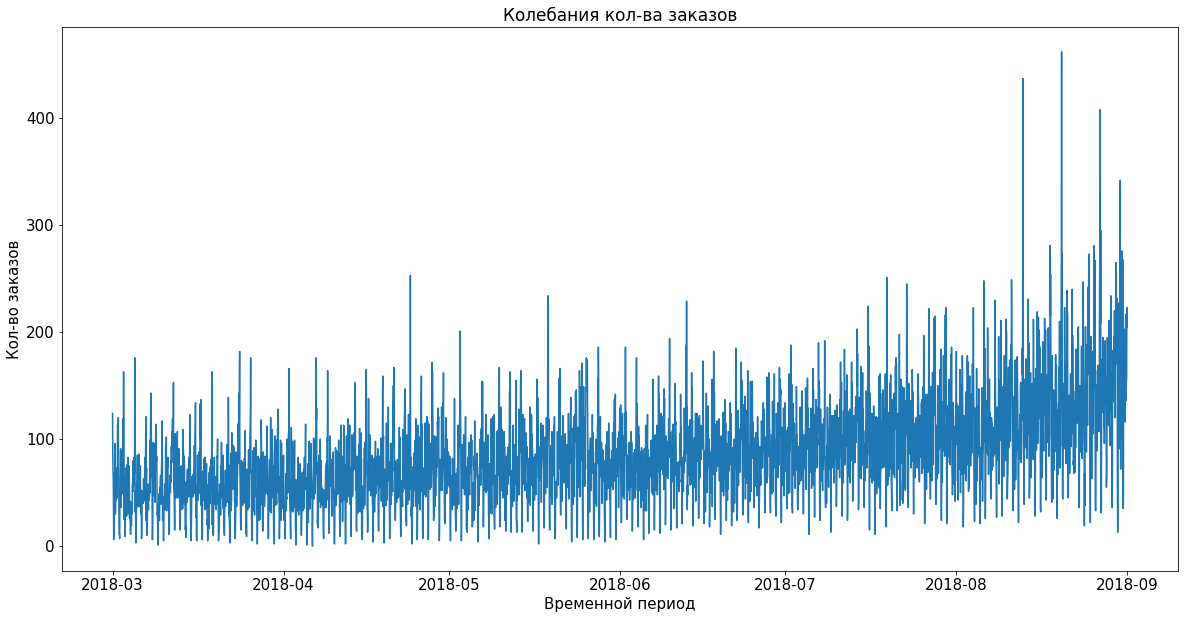

In [9]:
plt.figure(figsize=(20, 10)) # рассмотрим поподробнее распределение цен
ax = sns.lineplot(x='datetime', y='num_orders', data=data) #['2018-03-01':'2018-04-01']
ax.set_title('Колебания кол-ва заказов', fontsize=17)
ax.set_xlabel('Временной период',fontsize=15)
ax.set_ylabel('Кол-во заказов',fontsize=15)
ax.tick_params(labelsize=15);

**Промежуточный вывод:** Для подробностей лучше смотреть более короткие периоды, тем более у нас шаг - 1час. Пока же посмотрим, что происходит со скользящим средним и отклонениями, чтобы уловить укрупненную динамику:

In [10]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot['num_orders'].rolling(168).mean()
data_plot['std'] = data_plot['num_orders'].rolling(168).std()

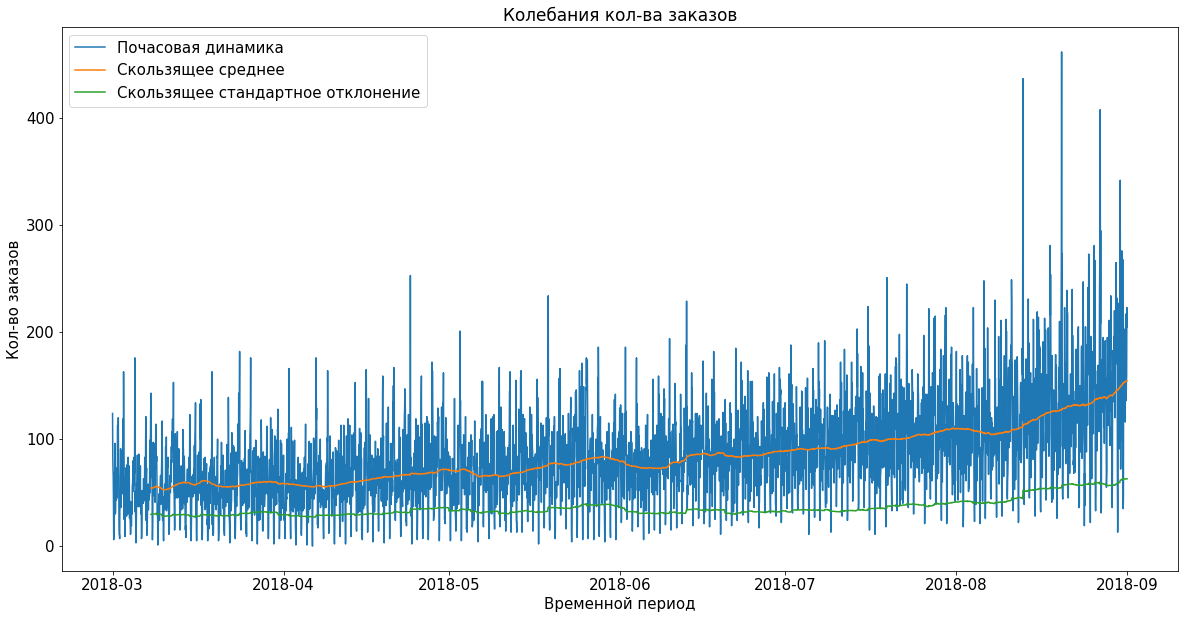

In [11]:
plt.figure(figsize=(20,10))
sns.lineplot(x='datetime', y='num_orders', data=data_plot, label='Почасовая динамика')
sns.lineplot(x='datetime', y='rolling_mean', data=data_plot, label='Скользящее среднее')
sns.lineplot(x='datetime', y='std', data=data_plot, label='Скользящее стандартное отклонение')
plt.title('Колебания кол-ва заказов', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15);

**Промежуточный вывод:** В целом наблюдается восходящий тренд в рамках имеющихся данных. Судя по изменениям средних и отклонений мы имеем дело с нестационарным временным рядом. Попробуем выделить тренд и сезонность:

In [12]:
decomposed = seasonal_decompose(data) #, model='additive'

#decomposed.seasonal[:169].plot()

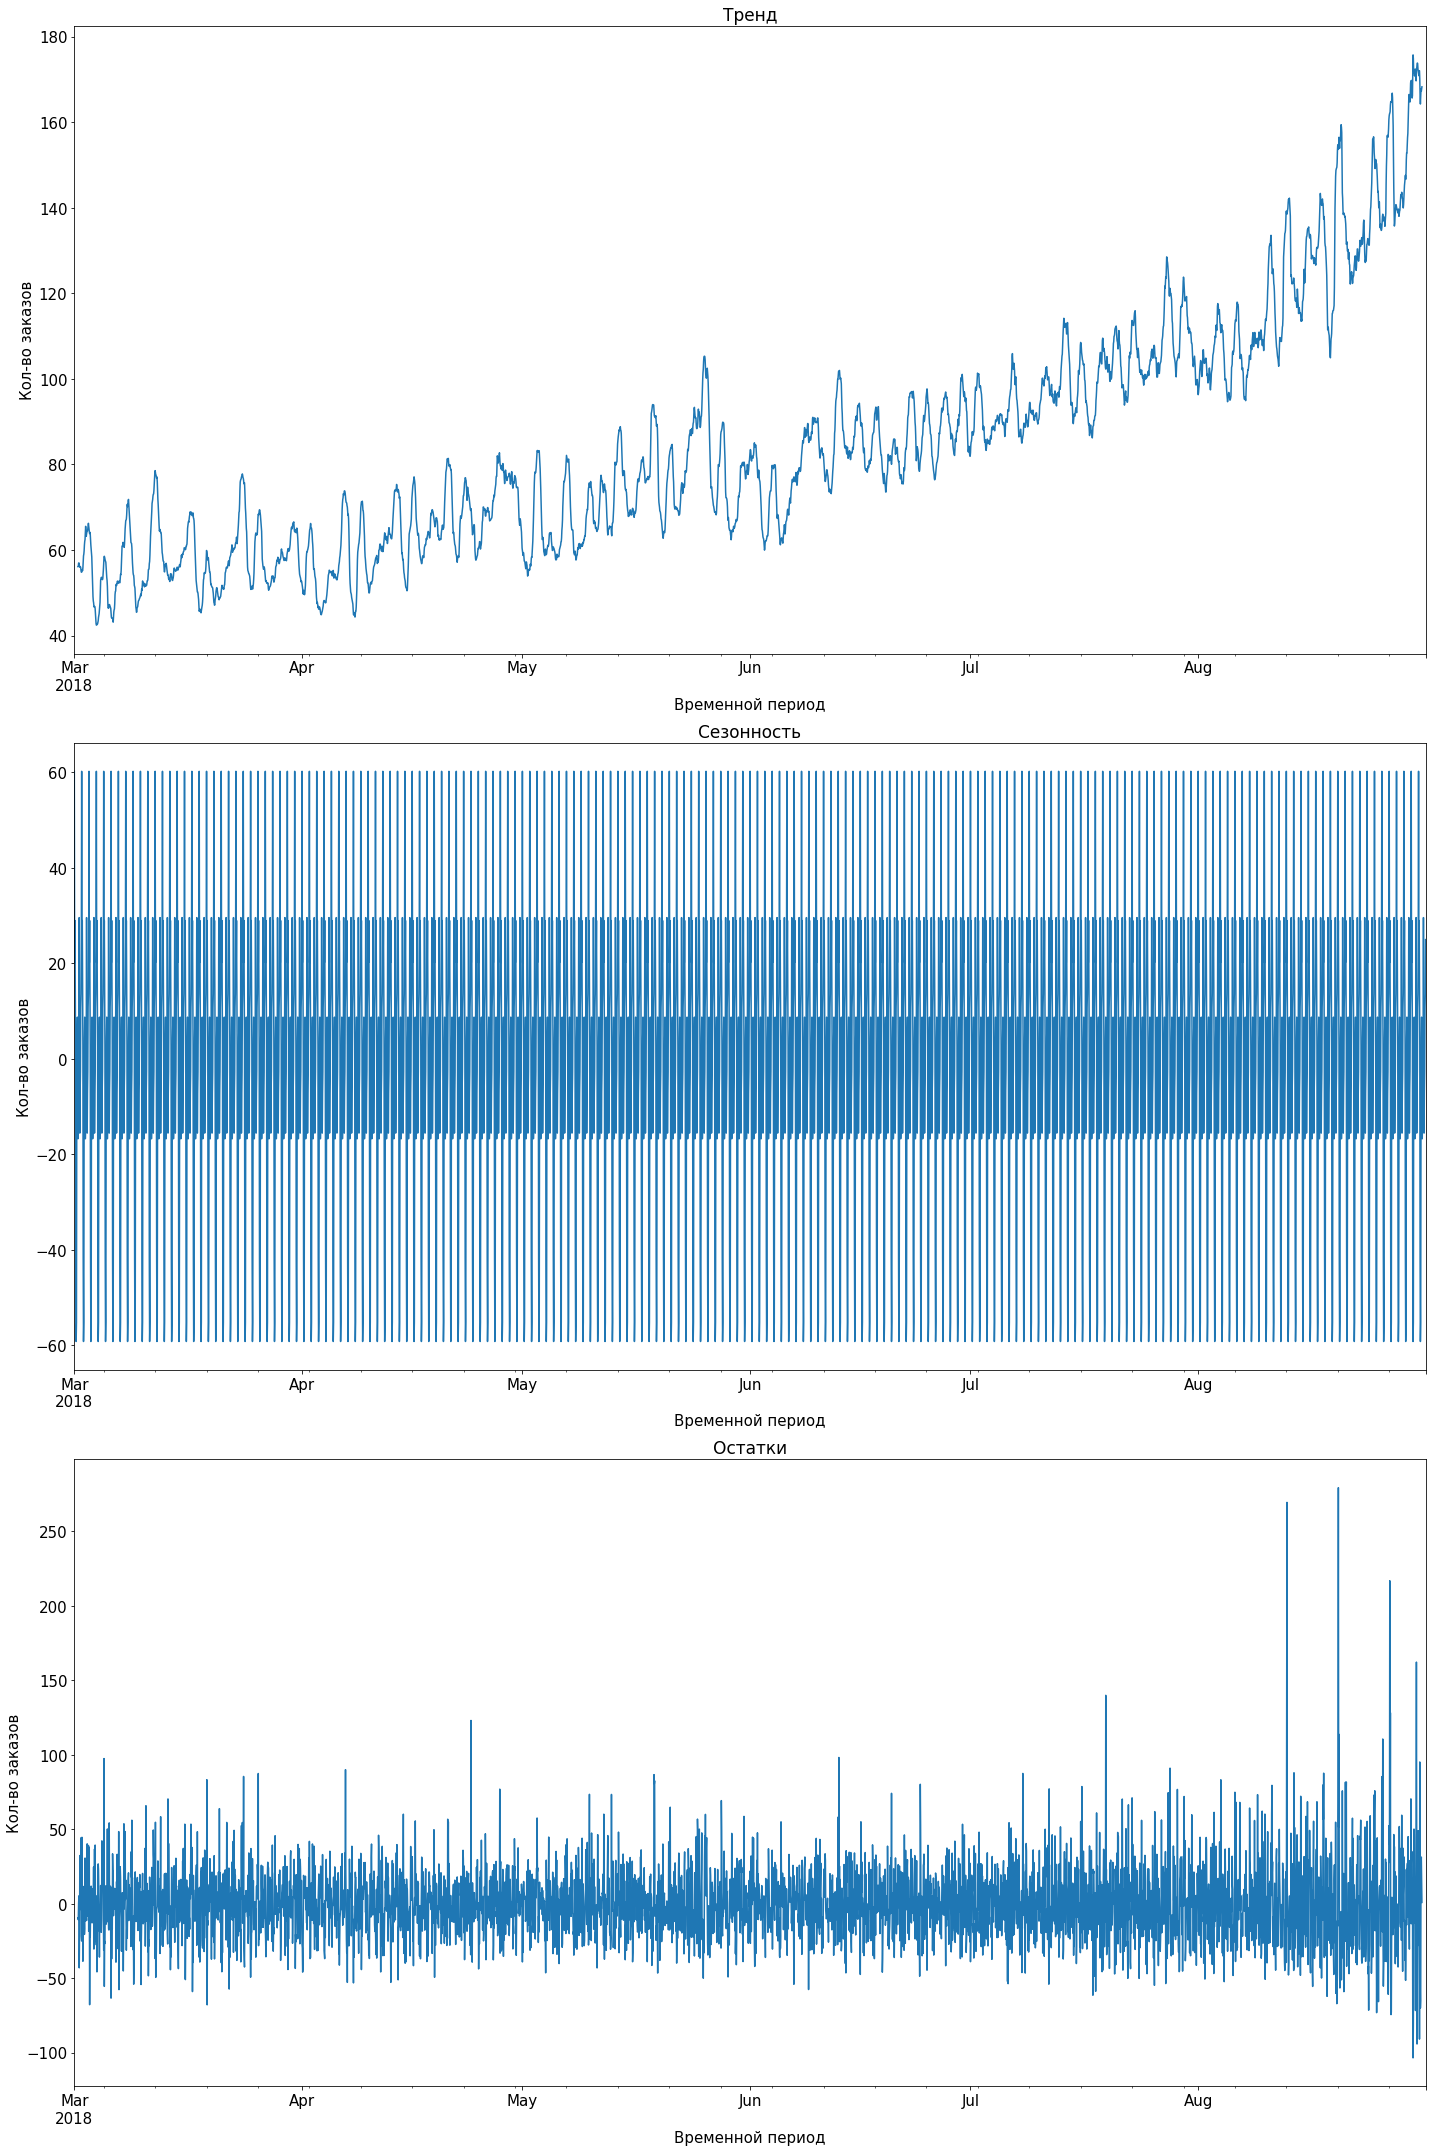

In [13]:
plt.figure(figsize=(20, 30))

plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() 
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) #[:25]
plt.title('Сезонность', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**Промежуточный вывод:** Так как у нас в распоряжении данные только за 6 месяцев, то о понимании какой-то ежегодной сезонности и сезонности от месяца к месяцу не приходится (если они и есть, то они уже учтены в восходящем тренде) поэтому посмотрим сезонность в рамках более короткого периода:

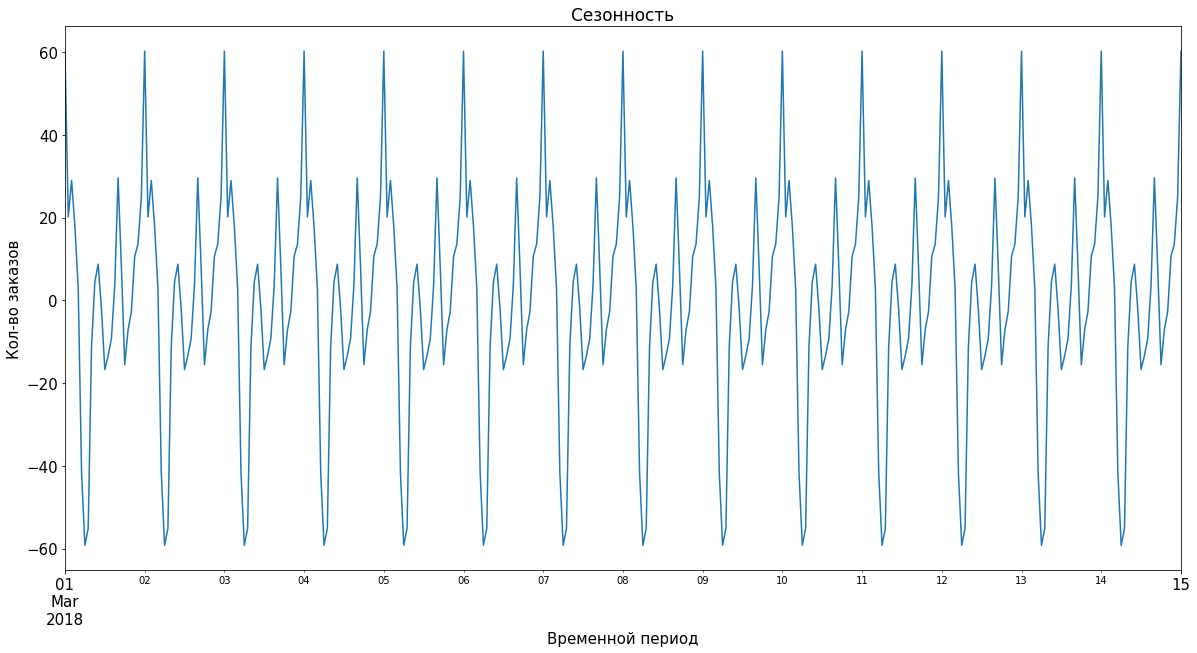

In [14]:
plt.figure(figsize=(20, 10))

decomposed.seasonal[:337].plot(ax=plt.gca()) #[:25]
plt.title('Сезонность', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15);

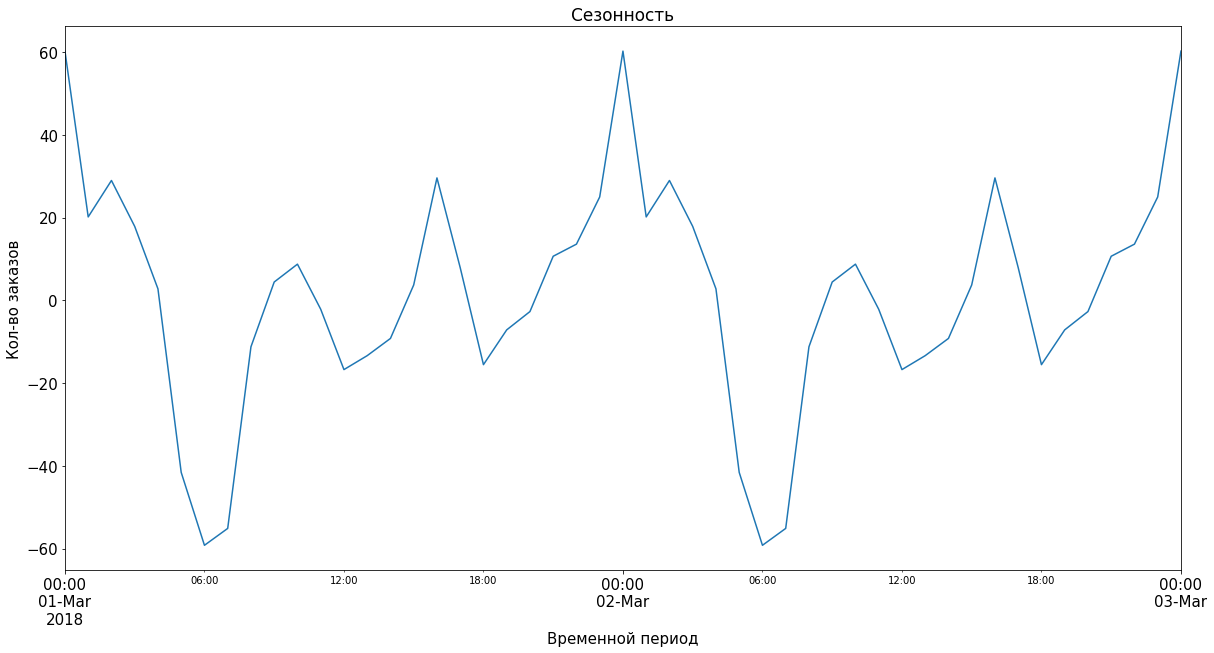

In [15]:
plt.figure(figsize=(20, 10))

decomposed.seasonal[:49].plot(ax=plt.gca()) #[:25]
plt.title('Сезонность', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15);

**Вывод:** Тренд плавный восходящий. Наблюдаем сезонность в рамках суток с пиками в районах 2, 9, 16 и 24 часов и спадами в районе 1, 6, 12 и 18 часов. Не стоит также отметать возможность сезонности относительно дня недели (понедельники могут быть похожи друг на друга и т.д.). Временной ряд сезонности уже более похож на стационарный, а значит его проще прогнозировать. Следует использовать фичи с информацией о часе и дне недели при обучении моделей.

## 3. Обучение

In [16]:
RS = 12345
TS = 0.1
NS = 8
cat_features = ['dayofweek', 'hour']

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

**Выбор стартовых параметров для фичей:** Шаг ряда, как и горизонт планирования - 1 час, а сезонность выражена в рамках суток и возможно зависит от дня недели, то начнем с лага в 1-2 часа (возьмем 2 по максимуму) и среднего за сутки, то есть за 24 часа. Если результаты на последующих шагах будут неудовлетворительны, то вернемся к этому шагу и пересмотрим параметры.

In [18]:
make_features(data, 2, 24)

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=TS, random_state=RS)
train = train.dropna()

In [20]:
features_train = train.drop(['num_orders'], axis=1) 
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

In [21]:
tscv = TimeSeriesSplit(n_splits=NS) #т.к. при разбиении на трен. и вал-ю выборки при cv требуется учитывать хронологию
#количество сплитов подобрано так, чтобы размер валидационной выборки примерно совпадал с размером тестовой

### Градиентный бустинг

In [22]:
cbr_parameters = { 'iterations': range(10, 51, 20),
                     'depth': range(1, 6, 2),
                     'learning_rate': np.arange(0.2, 0.9, 0.3) }
cbr_cv = GridSearchCV(CatBoostRegressor(random_seed=RS), param_grid=cbr_parameters, n_jobs=-1, cv=tscv, \
                      scoring='neg_root_mean_squared_error')
cbr_cv_df = cbr_cv.fit(features_train, target_train) #cat_features=cat_features убрал, с ними скор хуже, чем у ЛР выходил

0:	learn: 28.1128274	total: 46.2ms	remaining: 416ms
1:	learn: 27.5031575	total: 46.5ms	remaining: 186ms
2:	learn: 26.5931877	total: 46.8ms	remaining: 109ms
3:	learn: 25.9512717	total: 47.1ms	remaining: 70.6ms
4:	learn: 25.3068840	total: 47.3ms	remaining: 47.3ms
5:	learn: 24.8106497	total: 47.5ms	remaining: 31.7ms
6:	learn: 24.3528804	total: 47.7ms	remaining: 20.5ms
7:	learn: 24.0239233	total: 47.9ms	remaining: 12ms
8:	learn: 23.4256639	total: 48.1ms	remaining: 5.34ms
9:	learn: 23.1477942	total: 48.2ms	remaining: 0us
0:	learn: 28.5546789	total: 280us	remaining: 2.52ms
1:	learn: 27.6771787	total: 722us	remaining: 2.89ms
2:	learn: 26.9979103	total: 991us	remaining: 2.31ms
3:	learn: 26.5344796	total: 1.16ms	remaining: 1.74ms
4:	learn: 26.2125959	total: 1.3ms	remaining: 1.3ms
5:	learn: 25.7973176	total: 1.47ms	remaining: 981us
6:	learn: 25.3444800	total: 1.62ms	remaining: 693us
7:	learn: 24.9133270	total: 1.77ms	remaining: 443us
8:	learn: 24.5441640	total: 1.92ms	remaining: 213us
9:	learn: 

In [23]:
print(f'Значения лучших гиперпараметров для CatBoost: {cbr_cv_df.best_params_}')
print(f'Значение лучшего RMSE случайного леса при кросс-валидации: {-round(cbr_cv_df.best_score_, 2)}')

Значения лучших гиперпараметров для CatBoost: {'depth': 5, 'iterations': 50, 'learning_rate': 0.2}
Значение лучшего RMSE случайного леса при кросс-валидации: 24.82


**Промежутоный вывод:** Неожиданно бустинг показал более плохой RMSE при обозначении кат. фичей при обучении, возможно это связано с тем, что кат. фичи уже отчасти закодированы числовыми значениями.

### Линейная модель

Так как по условию задачи требуется пробовать разные гиперпараметры, то из линейных моделей возьмем, как вариант, ElasticNet. Для идущих далее линейных и деревянных моделей требуется произвести кодирование категориальных фичей.

In [24]:
data_ohe = pd.get_dummies(data, columns=cat_features, drop_first=True) # преобразуем кат. данные прямым кодированием

In [25]:
train_ohe, test_ohe = train_test_split(data_ohe, shuffle=False, test_size=TS, random_state=RS)
train_ohe = train_ohe.dropna()

In [26]:
features_train_ohe = train_ohe.drop(['num_orders'], axis=1) 
target_train_ohe = train_ohe['num_orders']
features_test_ohe = test_ohe.drop(['num_orders'], axis=1) 
target_test_ohe = test_ohe['num_orders']

In [27]:
features_train_ohe.shape

(3950, 32)

In [316]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
#features_test_ohe[
#    encoder_ohe.get_feature_names_out()
#] = encoder_ohe.transform(features_test_ohe[cat_features])

#features_test_ohe = features_test_ohe.drop(cat_features, axis=1)

In [28]:
features_test_ohe.shape

(442, 32)

In [29]:
en_parameters = { 'alpha': range(0, 2, 1),
                     'l1_ratio': np.arange(0, 1.1, 0.2) }

en_cv = GridSearchCV(ElasticNet(random_state=RS), param_grid=en_parameters, scoring='neg_root_mean_squared_error', \
                     n_jobs=-1, cv=tscv, verbose=10)
en_cv_df = en_cv.fit(features_train_ohe, target_train_ohe)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57672.56584054858, tolerance: 38.08030134529146
  model = cd_fast.enet_coordinate_descent(


[CV 1/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   0.3s
[CV 2/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140413.61300451154, tolerance: 76.7960923076923
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(

[CV 2/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   0.4s
[CV 3/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240836.90673621002, tolerance: 123.00882549167927
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


[CV 3/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   0.8s
[CV 4/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347452.6259730152, tolerance: 173.64114948863636
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


[CV 4/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   0.8s
[CV 5/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468548.0938470991, tolerance: 238.81852124658784
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   1.3s
[CV 6/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581960.3732970828, tolerance: 293.645724848255
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coo

[CV 6/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   1.4s
[CV 7/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701330.0915619845, tolerance: 358.0026860117111
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


[CV 7/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   1.7s
[CV 8/8; 1/4] START alpha=0, l1_ratio=0.8.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 865405.6395432568, tolerance: 448.5899676537585
  model = cd_fast.enet_coordinate_descent(


[CV 8/8; 1/4] END .....................alpha=0, l1_ratio=0.8; total time=   2.0s
[CV 1/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57672.56584054858, tolerance: 38.08030134529146
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(

[CV 1/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   0.5s
[CV 2/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140413.61300451154, tolerance: 76.7960923076923
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


[CV 2/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   0.5s
[CV 3/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240836.90673621002, tolerance: 123.00882549167927
  model = cd_fast.enet_coordinate_descent(


[CV 3/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   0.8s
[CV 4/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347452.6259730152, tolerance: 173.64114948863636
  model = cd_fast.enet_coordinate_descent(


[CV 4/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   1.2s
[CV 5/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 468548.0938470991, tolerance: 238.81852124658784
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit

[CV 5/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   1.1s
[CV 6/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581960.3732970828, tolerance: 293.645724848255
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)


[CV 6/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   1.2s
[CV 7/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701330.0915619845, tolerance: 358.0026860117111
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)


[CV 7/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   1.7s
[CV 8/8; 2/4] START alpha=0, l1_ratio=1.0.......................................


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 865405.6395432568, tolerance: 448.5899676537585
  model = cd_fast.enet_coordinate_descent(


[CV 8/8; 2/4] END .....................alpha=0, l1_ratio=1.0; total time=   1.9s
[CV 1/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 1/8; 3/4] END .....................alpha=1, l1_ratio=0.8; total time=   0.3s
[CV 2/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 2/8; 3/4] END .....................alpha=1, l1_ratio=0.8; total time=   0.1s
[CV 3/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 3/8; 3/4] END .....................alpha=1, l1_ratio=0.8; total time=   0.2s
[CV 4/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 4/8; 3/4] END .....................alpha=1, l1_ratio=0.8; total time=   0.3s
[CV 5/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 5/8; 3/4] END .....................alpha=1, l1_ratio=0.8; total time=   0.1s
[CV 6/8; 3/4] START alpha=1, l1_ratio=0.8.......................................
[CV 6/8; 3/4] END ..........

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1090858.4443230454, tolerance: 591.0646855949368
  model = cd_fast.enet_coordinate_descent(


In [30]:
print(f'Значения лучших регуляционных гиперпараметров для модели ElasticNet: {en_cv_df.best_params_}')
print(f'Значение RMSE модели ElasticNet при кросс-валидации: {-round(en_cv_df.best_score_, 2)}')

Значения лучших регуляционных гиперпараметров для модели ElasticNet: {'alpha': 0, 'l1_ratio': 0.8}
Значение RMSE модели ElasticNet при кросс-валидации: 24.99


Глянем для сравнения, что покажет обычная линейная регрессия на той же тренеровочной выборке на параметрах по умолчанию:

In [31]:
lr = LinearRegression() 
rmse_lr_scores = cross_val_score(lr, features_train_ohe, target_train_ohe, scoring='neg_root_mean_squared_error', \
                                            n_jobs=-1, cv=tscv)
rmse_lr_mean = rmse_lr_scores.mean()

In [32]:
print(f'Значение RMSE модели LinearRegression при кросс-валидации: {-round(rmse_lr_mean, 2)}')

Значение RMSE модели LinearRegression при кросс-валидации: 24.99


**Промежуточный вывод:** Обыкновенная линейная регрессия без настраиваемых гиперпараметров показала аналогичный ElasticNet результат на кросс-валидации, возможно это связано с тем, что в данной ситуации регуляризация особенно не требовалась. При отсутствии кодирования кат. фичей модели давали более плохой результат, так что кодирование было произведено не зря.

### Случайный лес

In [322]:
rf_parameters = { 'n_estimators': range(10, 51, 10),
                     'max_depth': [1, 5, 10] }
rf_cv = GridSearchCV(RandomForestRegressor(random_state=RS), param_grid=rf_parameters, n_jobs=-1, cv=tscv, 
                    scoring='neg_root_mean_squared_error')
rf_cv_df = rf_cv.fit(features_train, target_train)
#сначала обучал лес на данных с кодированием, однако без него он дал более хорошие результаты, а линейные модели с кодированием лучше

In [323]:
print(f'Значения лучших гиперпараметров для случаного леса: {rf_cv_df.best_params_}')
print(f'Значение лучшего RMSE случайного леса при кросс-валидации: {-round(rf_cv_df.best_score_, 2)}')

Значения лучших гиперпараметров для случаного леса: {'max_depth': 10, 'n_estimators': 50}
Значение лучшего RMSE случайного леса при кросс-валидации: 24.92


**Промежуточный вывод:** А вот случайный лес неожиданно выдал более плохой результат при использовании кодирования кат. фичей, а без кодирования выдал 2й результат после бустинга.

### Сравнение моделей

In [324]:
models_comparison = pd.DataFrame()
models_comparison['model'] = ['CatBoostRegressor', 'ElasticNet', 'RandomForestRegressor']
models_comparison['RMSE'] = [-cbr_cv_df.best_score_, -en_cv_df.best_score_, -rf_cv_df.best_score_]
models_comparison

,model,RMSE
0,CatBoostRegressor,24.821197
1,ElasticNet,24.986152
2,RandomForestRegressor,24.923689


**Вывод:** При очень близких результатах лучший результат показал CatBoost, однако стоит отметить, что при, казалось бы, более корректном использовании моделей: CatBoost с указанием кат. фичей при обучении и RandomForest с использованием кодирования для кат. столбцов они выдавали худшие результаты, чем линейные модели.

## Тестирование

Протестируем модель, показавшую лучший результат при обучении и сравним с константными моделями:

In [325]:
predicted_test_cbr = cbr_cv.best_estimator_.predict(features_test)

In [326]:
print(f'Значение RMSE модели CatBoostRegressor с лучшими гиперпараметрами на тестовой выборке: \
      {round(mean_squared_error(predicted_test_cbr, target_test, squared=False), 2)}')

Значение RMSE модели CatBoostRegressor с лучшими гиперпараметрами на тестовой выборке:       47.71


In [327]:
#predicted_test_en = en_cv.best_estimator_.predict(features_test_ohe)

In [328]:
#print(f'Значение RMSE модели ElasticNet с лучшими гиперпараметрами на тестовой выборке: \
#      {round(mean_squared_error(predicted_test_en, target_test, squared=False), 2)}')

In [329]:
#predicted_test_rf = rf_cv.best_estimator_.predict(features_test)

In [330]:
#print(f'Значение RMSE модели RandomForestRegressor с лучшими гиперпараметрами на тестовой выборке: \
#      {round(mean_squared_error(predicted_test_rf, target_test, squared=False), 2)}')

In [331]:
pred_median = np.ones(target_test.shape) * target_train.median()

In [332]:
print(f'RMSE константной модели на медиане: {round(mean_squared_error(pred_median, target_test, squared=False), 2)}')

RMSE константной модели на медиане: 87.15


In [333]:
pred_previous = target_test.shift(fill_value=target_train.iloc[-1])

In [334]:
print(f'RMSE константной модели на предыдущем значении: \
      {round(mean_squared_error(pred_previous, target_test, squared=False), 2)}')

RMSE константной модели на предыдущем значении:       58.86


In [335]:
models_testing_comparison = pd.DataFrame()
models_testing_comparison['model'] = ['CatBoostRegressor', 'Median_Dummy', 'Previous_Dummy']
models_testing_comparison['RMSE'] = [mean_squared_error(predicted_test_cbr, target_test, squared=False), \
mean_squared_error(pred_median, target_test, squared=False), \
                                     mean_squared_error(pred_previous, target_test, squared=False)]
models_testing_comparison

,model,RMSE
0,CatBoostRegressor,47.714679
1,Median_Dummy,87.152776
2,Previous_Dummy,58.856486


Посмотрим на графике сравнение предсказаний модели с реальными значениями тестового таргета на промежутке в неделю:

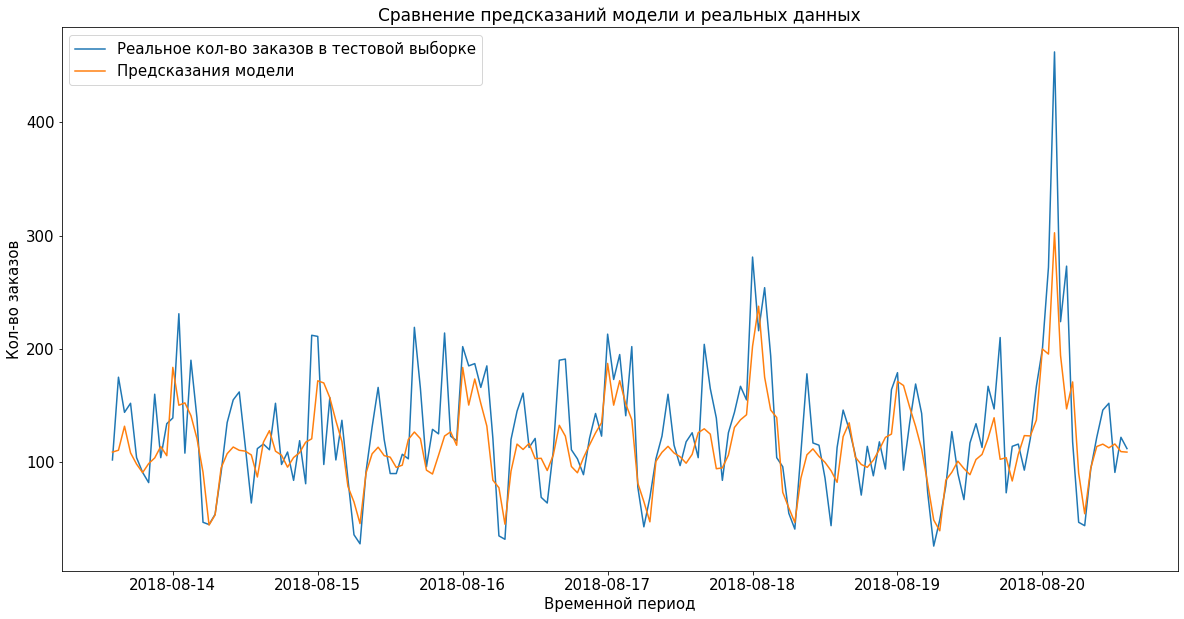

In [336]:
predictions_match = target_test.to_frame(name='target')
predictions_match['predictions'] = predicted_test_cbr

plt.figure(figsize=(20,10))
sns.lineplot(x=predictions_match[:169].index, y='target', data=predictions_match[:169], label='Реальное кол-во заказов в тестовой выборке')
sns.lineplot(x=predictions_match[:169].index, y='predictions', data=predictions_match[:169], label='Предсказания модели')
plt.title('Сравнение предсказаний модели и реальных данных', fontsize=17)
plt.xlabel('Временной период', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Кол-во заказов', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15);

**Вывод:** Модель CatBoostRegressor, показавшая лучший результат при обучении, на тестовой выборке выдала RMSE 47.71, что ниже заданного порога в 48. Достигнутый результат ощутимо превосходит метрики константных моделей. Что же касается реальных предсказаний, то из сравнительного графика видно, что в целом модель неплохо справляется: хорошо отрабатывает как колебания в рамках суток, так и отклонения в зависимости от разных дней недели. 